<a href="https://colab.research.google.com/github/Sayed-Hossein-Hosseini/HydroWizard_Intelligent_Fuzzy_Logic_Irrigation/blob/master/HydroWizard_Intelligent_Fuzzy_Logic_Irrigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HydroWizard_Intelligent_Fuzzy_Logic_Irrigation**

## **Libraries**

In [1]:
!pip install scikit-fuzzy

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from skfuzzy.defuzzify import defuzz
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.7 MB/s eta 0:00:00


## **Membership Functions**

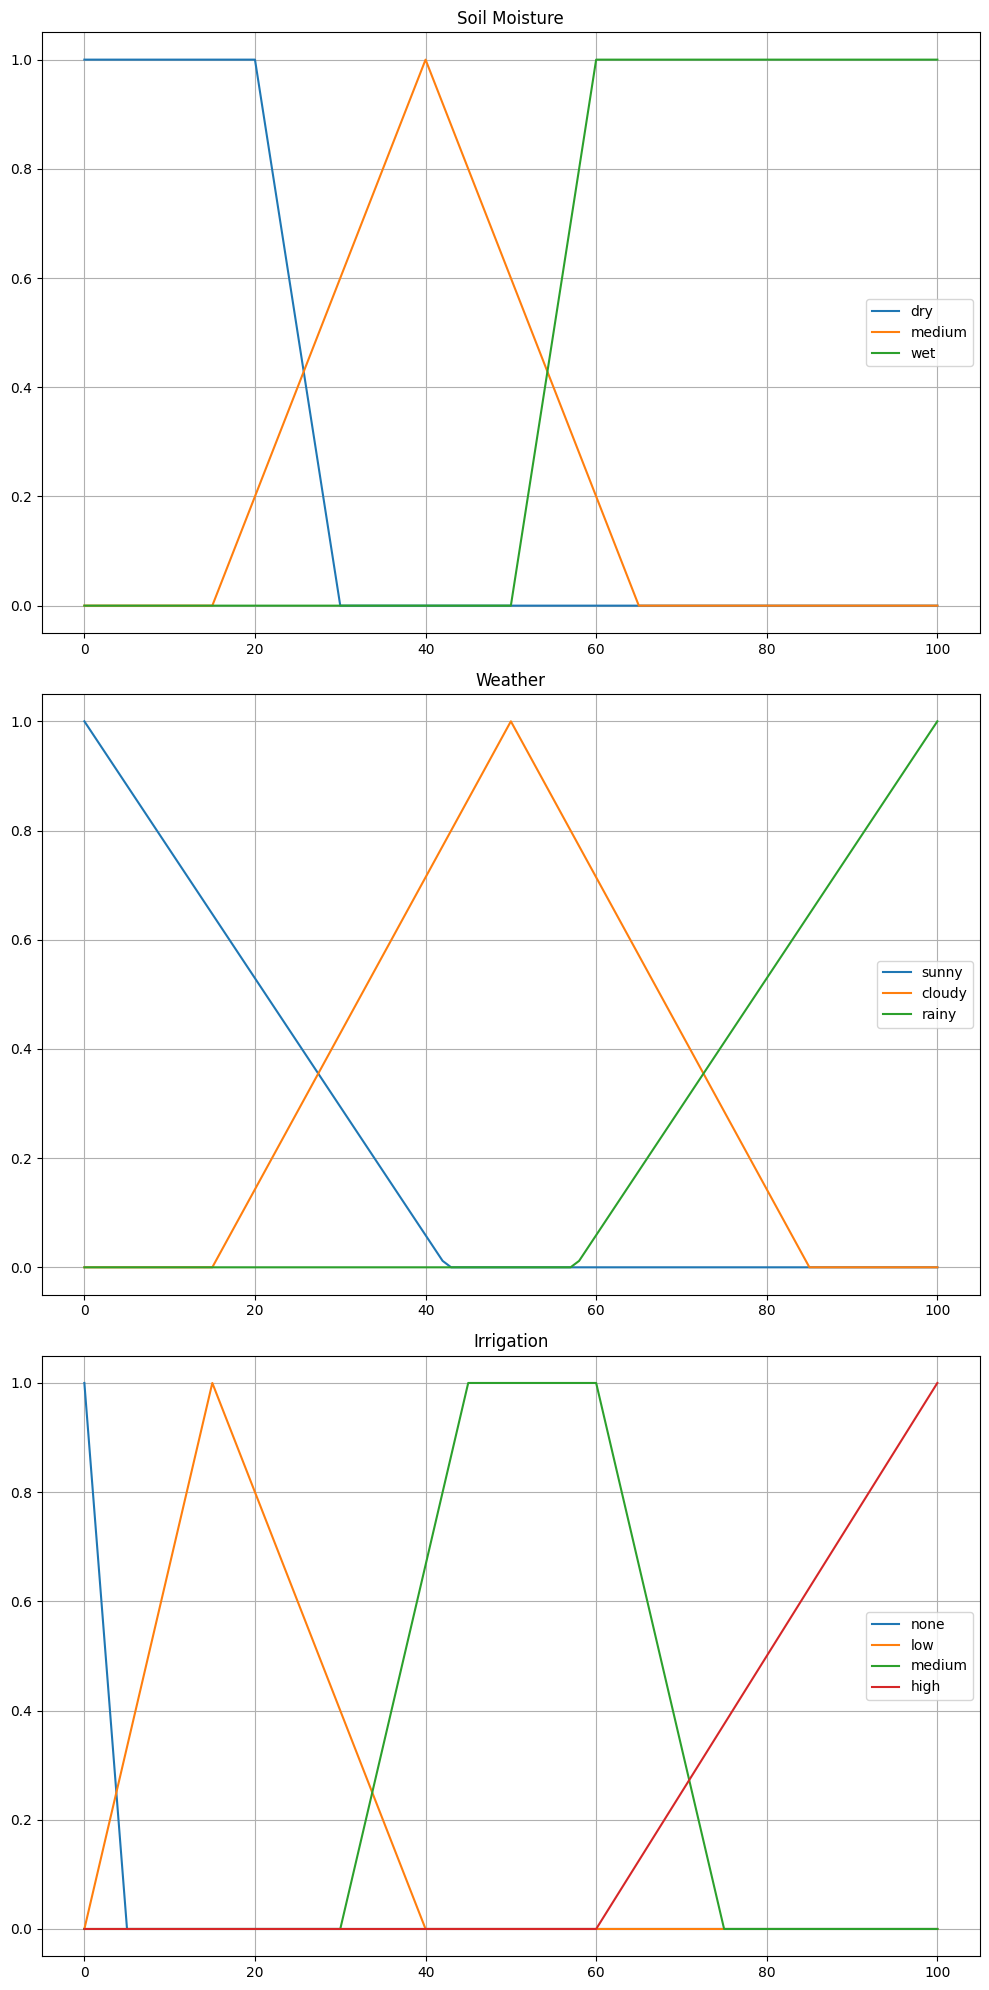

In [2]:
# Define the range of each variable (from 0 to 100)
soil_moisture = np.arange(0, 101, 1)
weather_range = np.arange(0, 101, 1)
irrigation_range = np.arange(0, 101, 1)

# Define fuzzy variables
soil = ctrl.Antecedent(soil_moisture, 'soil')
weather = ctrl.Antecedent(weather_range, 'weather')
irrigation = ctrl.Consequent(irrigation_range, 'irrigation')

# Membership functions for soil
soil['dry'] = fuzz.trapmf(soil.universe, [-1, 0, 20, 30])
soil['medium'] = fuzz.trimf(soil.universe, [15, 40, 65])
soil['wet'] = fuzz.trapmf(soil.universe, [50, 60, 100, 101])

# Membership functions for weather
weather['sunny'] = fuzz.trimf(weather.universe, [0, 0, 42.5])
weather['cloudy'] = fuzz.trimf(weather.universe, [15, 50, 85])
weather['rainy'] = fuzz.trimf(weather.universe, [57.5, 100, 100])

# Membership functions for irrigation
irrigation['none'] = fuzz.trimf(irrigation.universe, [-1, 0, 5])
irrigation['low'] = fuzz.trimf(irrigation.universe, [0, 15, 40])
irrigation['medium'] = fuzz.trapmf(irrigation.universe, [30, 45, 60, 75])
irrigation['high'] = fuzz.trimf(irrigation.universe, [60, 100, 101])

def plot_mf(var, var_name, ax):
    for label in var.terms:
        mf = var.terms[label].mf
        ax.plot(var.universe, mf, label=label)
    ax.set_title(var_name)
    ax.legend()
    ax.grid(True)

# Plotting the fuzzy sets
fig, axs = plt.subplots(nrows=3, figsize=(10, 20))
# axs = axs.flatten()

plot_mf(soil, 'Soil Moisture', axs[0]) # Plot fuzzy sets for soil moisture
plot_mf(weather, 'Weather', axs[1]) # Plot fuzzy sets for weather
plot_mf(irrigation, 'Irrigation', axs[2]) # Plot fuzzy sets for irrigation

plt.tight_layout()
plt.show()

## **Control Rules and Defuzzification**

### **Fuzzy Logic Rules**

In [3]:
# Define fuzzy rules based on the given chart
rule1 = ctrl.Rule(soil['dry'] & weather['sunny'], irrigation['high'])
rule2 = ctrl.Rule(soil['dry'] & weather['cloudy'], irrigation['medium'])
rule3 = ctrl.Rule(soil['dry'] & weather['rainy'], irrigation['low'])

rule4 = ctrl.Rule(soil['medium'] & weather['sunny'], irrigation['medium'])
rule5 = ctrl.Rule(soil['medium'] & weather['cloudy'], irrigation['low'])
rule6 = ctrl.Rule(soil['medium'] & weather['rainy'], irrigation['none'])

rule7 = ctrl.Rule(soil['wet'] & weather['sunny'], irrigation['low'])
rule8 = ctrl.Rule(soil['wet'] & weather['cloudy'], irrigation['none'])
rule9 = ctrl.Rule(soil['wet'] & weather['rainy'], irrigation['none'])

### **Control Rules**

In [4]:
# Create the control system and simulation
irrigation_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
irrigation_sim = ctrl.ControlSystemSimulation(irrigation_ctrl)

### **Defuzzification**

#### **Membership Level Of Entries**

In [5]:
def input_value(soil_val=30, weather_val=20):
    return soil_val, weather_val

soil_val, weather_val = input_value()

μ_soil_dry = fuzz.interp_membership(soil.universe, soil['dry'].mf, soil_val)
μ_soil_medium = fuzz.interp_membership(soil.universe, soil['medium'].mf, soil_val)
μ_soil_wet = fuzz.interp_membership(soil.universe, soil['wet'].mf, soil_val)

μ_weather_sunny = fuzz.interp_membership(weather.universe, weather['sunny'].mf, weather_val)
μ_weather_cloudy = fuzz.interp_membership(weather.universe, weather['cloudy'].mf, weather_val)
μ_weather_rainy = fuzz.interp_membership(weather.universe, weather['rainy'].mf, weather_val)

print("Soil Membership Degrees:")
print(f"  Dry:    {μ_soil_dry:.2f}")
print(f"  Medium: {μ_soil_medium:.2f}")
print(f"  Wet:    {μ_soil_wet:.2f}")

print("Weather Membership Degrees:")
print(f"  Sunny:  {μ_weather_sunny:.2f}")
print(f"  Cloudy: {μ_weather_cloudy:.2f}")
print(f"  Rainy:  {μ_weather_rainy:.2f}")

Soil Membership Degrees:
  Dry:    0.00
  Medium: 0.60
  Wet:    0.00
Weather Membership Degrees:
  Sunny:  0.53
  Cloudy: 0.14
  Rainy:  0.00


#### **Activation Rules**

In [6]:
activation_rule1 = np.fmin(μ_soil_dry, μ_weather_sunny)     # → irrigation high
activation_rule2 = np.fmin(μ_soil_dry, μ_weather_cloudy)    # → irrigation medium
activation_rule3 = np.fmin(μ_soil_dry, μ_weather_rainy)     # → irrigation low

activation_rule4 = np.fmin(μ_soil_medium, μ_weather_sunny)  # → irrigation medium
activation_rule5 = np.fmin(μ_soil_medium, μ_weather_cloudy) # → irrigation low
activation_rule6 = np.fmin(μ_soil_medium, μ_weather_rainy)  # → irrigation none

activation_rule7 = np.fmin(μ_soil_wet, μ_weather_sunny)     # → irrigation low
activation_rule8 = np.fmin(μ_soil_wet, μ_weather_cloudy)    # → irrigation none
activation_rule9 = np.fmin(μ_soil_wet, μ_weather_rainy)     # → irrigation none

#### **Cutting**

In [7]:
irrigation_high_cut    = np.fmin(activation_rule1, irrigation['high'].mf)
irrigation_medium_cut1 = np.fmin(activation_rule2, irrigation['medium'].mf)
irrigation_medium_cut2 = np.fmin(activation_rule4, irrigation['medium'].mf)
irrigation_low_cut1    = np.fmin(activation_rule3, irrigation['low'].mf)
irrigation_low_cut2    = np.fmin(activation_rule5, irrigation['low'].mf)
irrigation_low_cut3    = np.fmin(activation_rule7, irrigation['low'].mf)
irrigation_none_cut1   = np.fmin(activation_rule6, irrigation['none'].mf)
irrigation_none_cut2   = np.fmin(activation_rule8, irrigation['none'].mf)
irrigation_none_cut3   = np.fmin(activation_rule9, irrigation['none'].mf)

#### **Aggregation**

In [8]:
aggregated_output = np.fmax(
    irrigation_high_cut,
    np.fmax(irrigation_medium_cut1,
    np.fmax(irrigation_medium_cut2,
    np.fmax(irrigation_low_cut1,
    np.fmax(irrigation_low_cut2,
    np.fmax(irrigation_low_cut3,
    np.fmax(irrigation_none_cut1,
    np.fmax(irrigation_none_cut2, irrigation_none_cut3))))))))

#### **Crisp**

##### **Centroid**

In [9]:
crisp_output_centroid = fuzz.defuzz(irrigation.universe, aggregated_output, 'centroid')
print(f"\nFinal Irrigation Output (Centroid): {crisp_output_centroid:.2f}")


Final Irrigation Output (Centroid): 45.97


##### **Visualization**

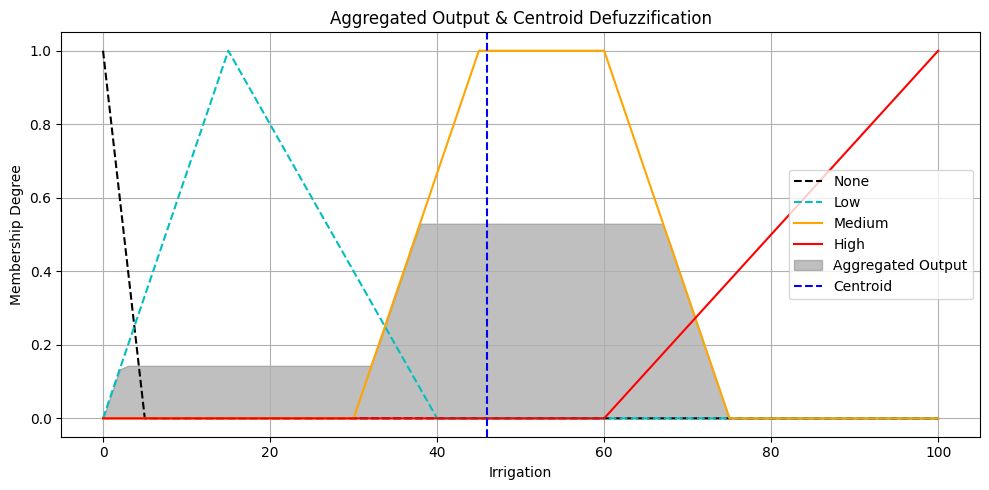

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_centroid, color='blue', linestyle='--', label='Centroid')

plt.title('Aggregated Output & Centroid Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **First Maximum**

In [11]:
crisp_output_FM = fuzz.defuzz(irrigation.universe, aggregated_output, 'som')
print(f"\nFinal Irrigation Output (First of Maximum): {crisp_output_FM:.2f}")


Final Irrigation Output (First of Maximum): 38.00


##### **Visualization**

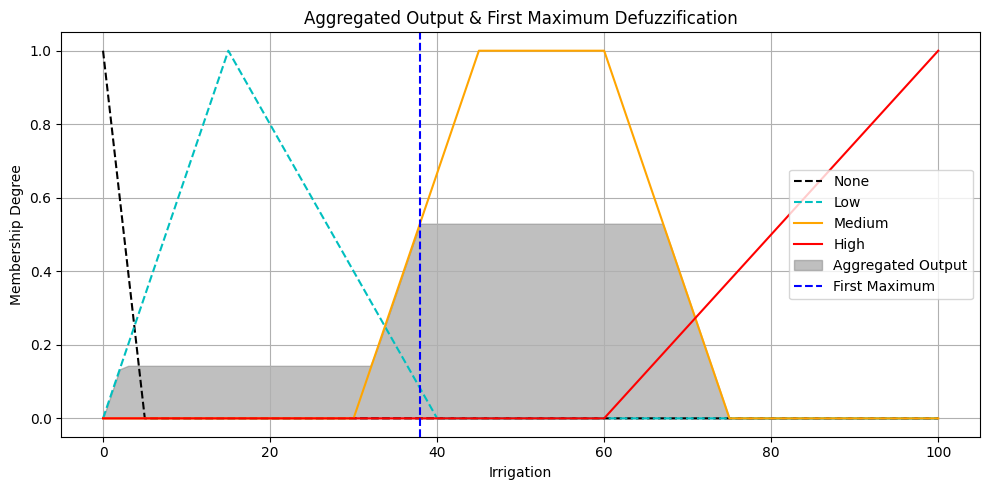

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_FM, color='blue', linestyle='--', label='First Maximum')

plt.title('Aggregated Output & First Maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **Middle Maximum**

In [13]:
crisp_output_MM = fuzz.defuzz(irrigation.universe, aggregated_output, 'mom')
print(f"\nFinal Irrigation Output (Mean of Maximum): {crisp_output_MM:.2f}")


Final Irrigation Output (Mean of Maximum): 52.50


##### **Visualization**

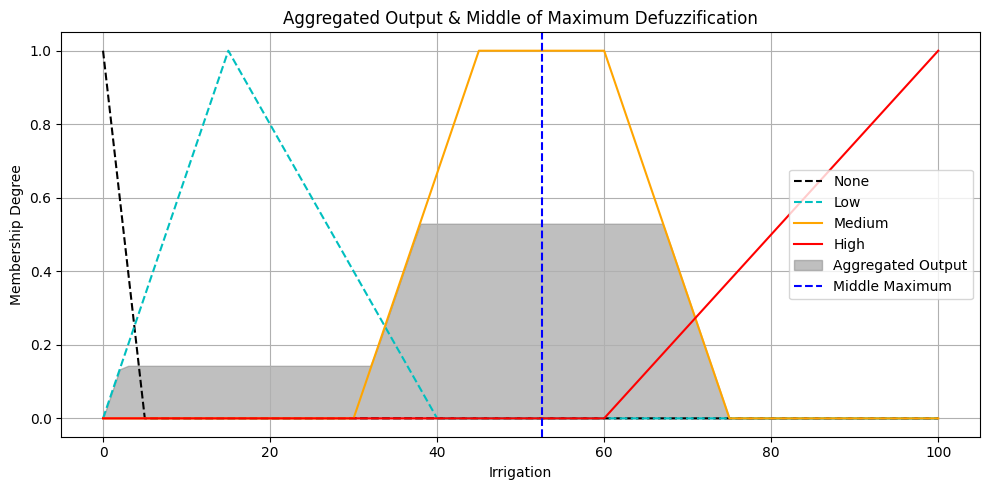

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_MM, color='blue', linestyle='--', label='Middle Maximum')

plt.title('Aggregated Output & Middle of Maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **Last Maximum**

In [15]:
crisp_output_LM = fuzz.defuzz(irrigation.universe, aggregated_output, 'lom')
print(f"\nFinal Irrigation Output (Last of Maximum): {crisp_output_LM:.2f}")


Final Irrigation Output (Last of Maximum): 67.00


##### **Visualization**

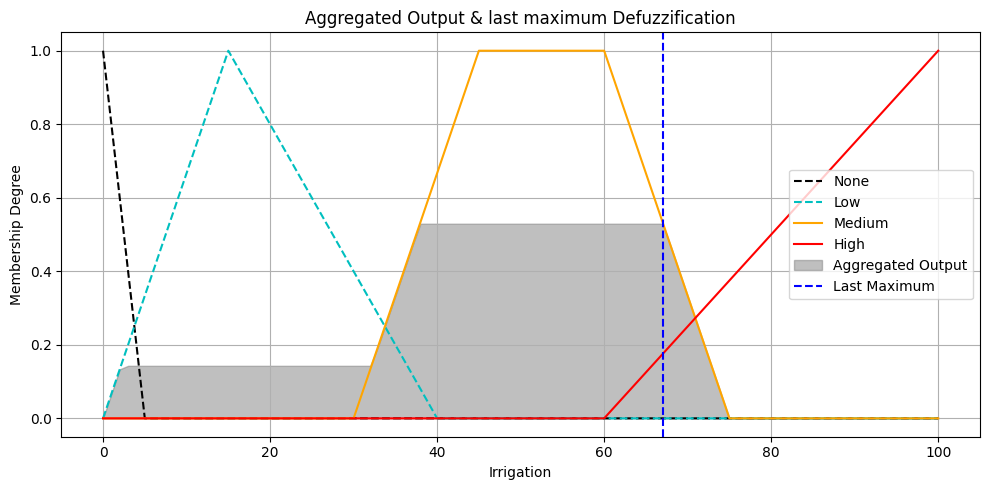

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_LM, color='blue', linestyle='--', label='Last Maximum')

plt.title('Aggregated Output & last maximum Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### **Center Of The Surface**

In [18]:
crisp_output_bisector = fuzz.defuzz(irrigation.universe, aggregated_output, 'bisector')
print(f"\nFinal Irrigation Output (bisector): {crisp_output_bisector:.2f}")


Final Irrigation Output (bisector): 48.45


##### **Visualization**

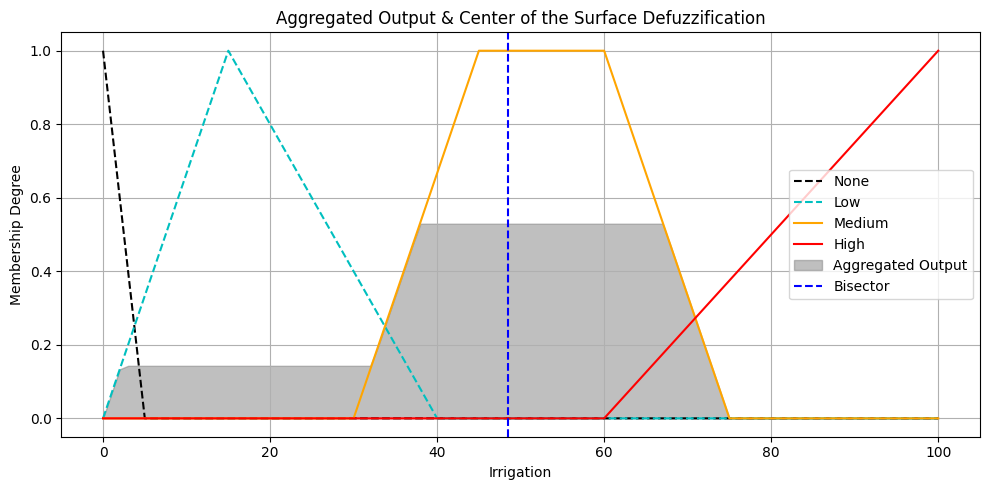

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output_bisector, color='blue', linestyle='--', label='Bisector')

plt.title('Aggregated Output & Center of the Surface Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Simulation and Analysis**

### **10 Day Timeframe**

Day 1: Weather=Sunny, Evap=5.98, Rain=0.00, Soil Moisture=50.00% → 67.00%, Irrigation=45.97%
Day 2: Weather=Sunny, Evap=7.86, Rain=0.00, Soil Moisture=67.00% → 68.47%, Irrigation=18.65%
Day 3: Weather=Sunny, Evap=7.00, Rain=0.00, Soil Moisture=68.47% → 70.80%, Irrigation=18.65%
Day 4: Weather=Sunny, Evap=5.99, Rain=0.00, Soil Moisture=70.80% → 74.14%, Irrigation=18.65%
Day 5: Weather=Cloudy, Evap=3.32, Rain=0.00, Soil Moisture=74.14% → 71.66%, Irrigation=1.67%
Day 6: Weather=Cloudy, Evap=2.94, Rain=0.00, Soil Moisture=71.66% → 69.56%, Irrigation=1.67%
Day 7: Weather=Cloudy, Evap=3.12, Rain=0.00, Soil Moisture=69.56% → 67.27%, Irrigation=1.67%
Day 8: Weather=Rainy, Evap=0.54, Rain=15.26, Soil Moisture=67.27% → 82.95%, Irrigation=1.92%
Day 9: Weather=Rainy, Evap=1.46, Rain=14.77, Soil Moisture=82.95% → 97.22%, Irrigation=1.92%
Day 10: Weather=Rainy, Evap=0.68, Rain=18.57, Soil Moisture=97.22% → 100.00%, Irrigation=1.92%


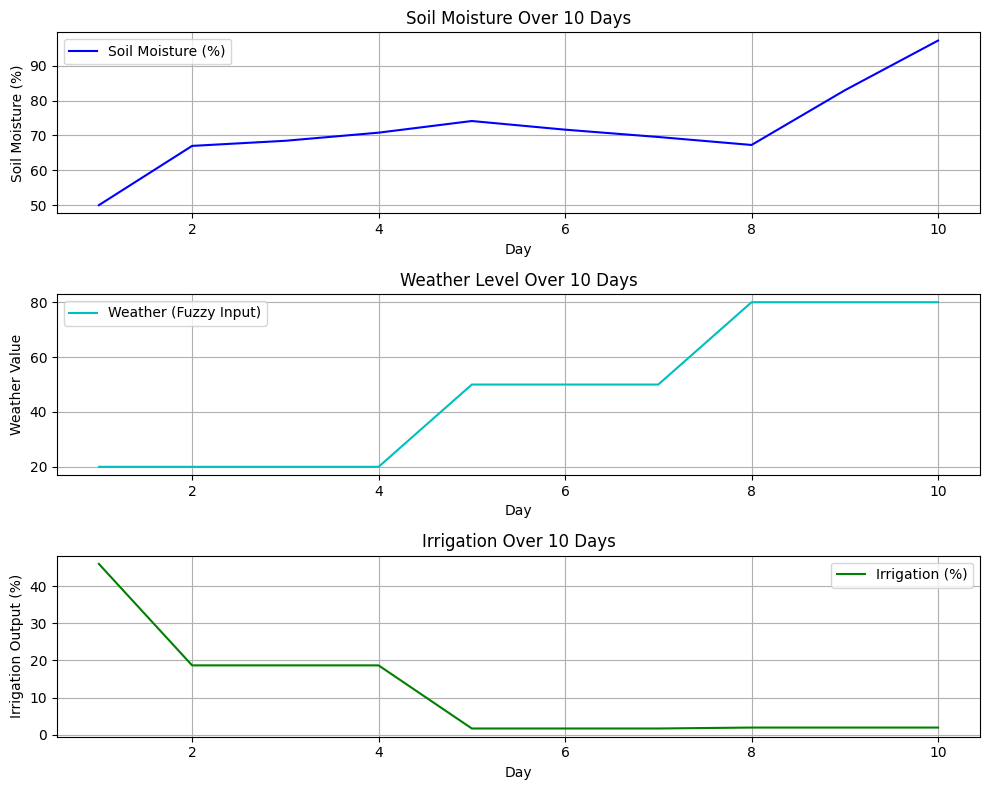

In [20]:
days = 10
soil_moisture_values = [50]  # Initial soil moisture
weather_values = []
irrigation_values = []

weather_map = {
    "Sunny": 20,
    "Cloudy": 50,
    "Rainy": 80
}

for day in range(days):
    if 0 <= day <= 3:
        weather_str = "Sunny"
        evap = np.random.uniform(5, 8)
        rain_effect = 0
    elif 4 <= day <= 6:
        weather_str = "Cloudy"
        evap = np.random.uniform(2, 4)
        rain_effect = 0
    else:
        weather_str = "Rainy"
        evap = np.random.uniform(0.5, 1.5)
        rain_effect = np.random.uniform(10, 20)  # The effect of rain on soil

    weather_values.append(weather_str)

    # Input to the fuzzy system
    soil_input = soil_moisture_values[-1]
    weather_input = weather_map[weather_str]

    irrigation_sim.input['soil'] = soil_input
    irrigation_sim.input['weather'] = weather_input
    irrigation_sim.compute()

    irrigation_amount = irrigation_sim.output['irrigation']
    irrigation_values.append(irrigation_amount)

    # Calculating new soil moisture using the modified equation
    new_moisture = soil_input - evap + (irrigation_amount * 0.5) + rain_effect
    new_moisture = np.clip(new_moisture, 0, 100)
    soil_moisture_values.append(new_moisture)

    # Print daily information
    print(f"Day {day+1}: Weather={weather_str}, Evap={evap:.2f}, Rain={rain_effect:.2f}, Soil Moisture={soil_input:.2f}% → {new_moisture:.2f}%, Irrigation={irrigation_amount:.2f}%")

# Drawing diagrams
days_axis = range(1, days + 1)
plt.figure(figsize=(10, 8))

# Soil moisture
plt.subplot(3, 1, 1)
plt.plot(days_axis, soil_moisture_values[:-1], 'b-', label='Soil Moisture (%)')
plt.title('Soil Moisture Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Soil Moisture (%)')
plt.grid(True)
plt.legend()

# Weather conditions in numbers
weather_numeric = [weather_map[w] for w in weather_values]
plt.subplot(3, 1, 2)
plt.plot(days_axis, weather_numeric, 'c-', label='Weather (Fuzzy Input)')
plt.title('Weather Level Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Weather Value')
plt.grid(True)
plt.legend()

# Irrigation
plt.subplot(3, 1, 3)
plt.plot(days_axis, irrigation_values, 'g-', label='Irrigation (%)')
plt.title('Irrigation Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Irrigation Output (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### **Analysis and Review**

In [21]:
# Define optimal, under, and over moisture zones
optimal_min = 40
optimal_max = 80

in_range_days = 0
under_moisture_days = 0
over_moisture_days = 0

# Categorize each day's moisture level
for moisture in soil_moisture_values[:-1]:  # Last value is t+1 and unused
    if optimal_min <= moisture <= optimal_max:
        in_range_days += 1
    elif moisture < optimal_min:
        under_moisture_days += 1
    elif moisture > optimal_max:
        over_moisture_days += 1

# Calculate percentages
success_rate = (in_range_days / days) * 100
under_rate = (under_moisture_days / days) * 100
over_rate = (over_moisture_days / days) * 100

# Display full performance analysis
print("\n📊 Detailed Performance Analysis:")
print(f"Optimal Moisture Range: {optimal_min}% to {optimal_max}%")
print(f"Days in Optimal Range: {in_range_days} ({success_rate:.2f}%)")
print(f"Days Under Optimal Range: {under_moisture_days} ({under_rate:.2f}%)")
print(f"Days Over Optimal Range: {over_moisture_days} ({over_rate:.2f}%)")

if over_rate > 40:
    print("This type of irrigation is recommended for greenhouses with high humidity.")
elif under_rate > 20:
    print("This type of irrigation is recommended for greenhouses with low humidity.")
else:
    print("The fuzzy controller maintains soil moisture efficiently within the desired range.")


📊 Detailed Performance Analysis:
Optimal Moisture Range: 40% to 80%
Days in Optimal Range: 8 (80.00%)
Days Under Optimal Range: 0 (0.00%)
Days Over Optimal Range: 2 (20.00%)
The fuzzy controller maintains soil moisture efficiently within the desired range.


## **Increasing Rules and Re-Simulation**

### **Membership Functions**

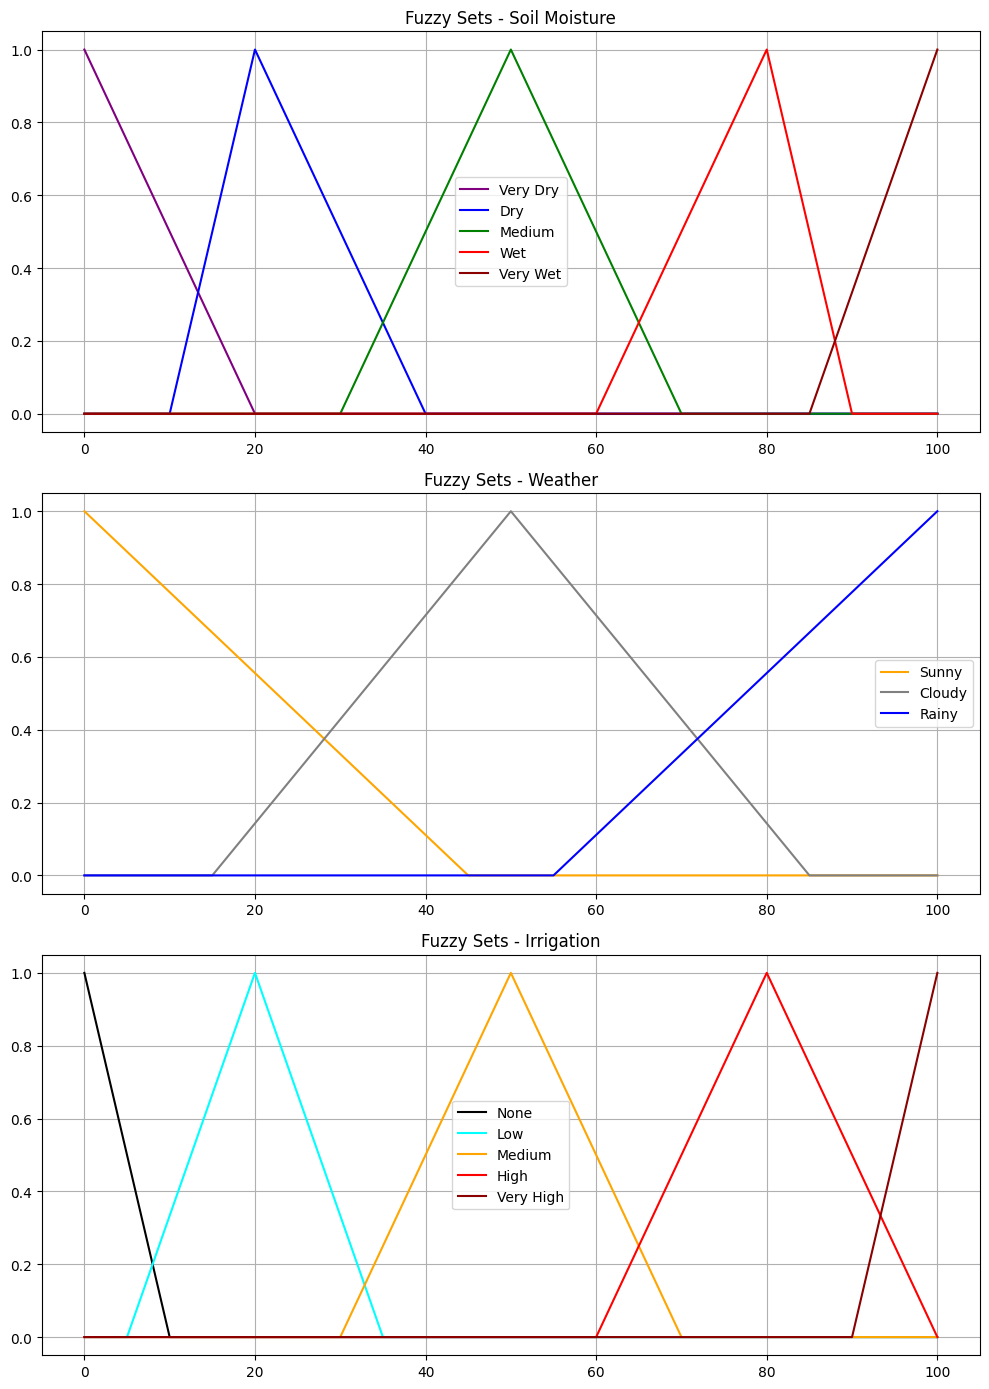

In [22]:
# Define the range of each variable (from 0 to 100)
soil_moisture = np.arange(0, 101, 1)
weather_range = np.arange(0, 101, 1)
irrigation_range = np.arange(0, 101, 1)

# Define fuzzy variables
soil = ctrl.Antecedent(soil_moisture, 'soil')
weather = ctrl.Antecedent(weather_range, 'weather')
irrigation = ctrl.Consequent(irrigation_range, 'irrigation')

# Updated membership functions for soil
soil['very_dry'] = fuzz.trimf(soil.universe, [0, 0, 20])
soil['dry'] = fuzz.trimf(soil.universe, [10, 20, 40])
soil['medium'] = fuzz.trimf(soil.universe, [30, 50, 70])
soil['wet'] = fuzz.trimf(soil.universe, [60, 80, 90])
soil['very_wet'] = fuzz.trimf(soil.universe, [85, 100, 100])

# Membership functions for weather (unchanged)
weather['sunny'] = fuzz.trimf(weather.universe, [0, 0, 45])
weather['cloudy'] = fuzz.trimf(weather.universe, [15, 50, 85])
weather['rainy'] = fuzz.trimf(weather.universe, [55, 100, 100])

# Updated membership functions for irrigation
irrigation['none'] = fuzz.trimf(irrigation.universe, [0, 0, 10])
irrigation['low'] = fuzz.trimf(irrigation.universe, [5, 20, 35])
irrigation['medium'] = fuzz.trimf(irrigation.universe, [30, 50, 70])
irrigation['high'] = fuzz.trimf(irrigation.universe, [60, 80, 100])
irrigation['very_high'] = fuzz.trimf(irrigation.universe, [90, 100, 100])

# Manual definitions for plotting
soil_very_dry = fuzz.trimf(soil_moisture, [0, 0, 20])
soil_dry = fuzz.trimf(soil_moisture, [10, 20, 40])
soil_medium = fuzz.trimf(soil_moisture, [30, 50, 70])
soil_wet = fuzz.trimf(soil_moisture, [60, 80, 90])
soil_very_wet = fuzz.trimf(soil_moisture, [85, 100, 100])

weather_sunny = fuzz.trimf(weather_range, [0, 0, 45])
weather_cloudy = fuzz.trimf(weather_range, [15, 50, 85])
weather_rainy = fuzz.trimf(weather_range, [55, 100, 100])

irrigation_none = fuzz.trimf(irrigation_range, [0, 0, 10])
irrigation_low = fuzz.trimf(irrigation_range, [5, 20, 35])
irrigation_medium = fuzz.trimf(irrigation_range, [30, 50, 70])
irrigation_high = fuzz.trimf(irrigation_range, [60, 80, 100])
irrigation_very_high = fuzz.trimf(irrigation_range, [90, 100, 100])

# Plotting fuzzy sets
fig, axs = plt.subplots(nrows=3, figsize=(10, 14))

# Soil Moisture
axs[0].plot(soil_moisture, soil_very_dry, 'purple', label='Very Dry')
axs[0].plot(soil_moisture, soil_dry, 'b', label='Dry')
axs[0].plot(soil_moisture, soil_medium, 'g', label='Medium')
axs[0].plot(soil_moisture, soil_wet, 'r', label='Wet')
axs[0].plot(soil_moisture, soil_very_wet, 'darkred', label='Very Wet')
axs[0].set_title('Fuzzy Sets - Soil Moisture')
axs[0].legend()
axs[0].grid(True)

# Weather
axs[1].plot(weather_range, weather_sunny, 'orange', label='Sunny')
axs[1].plot(weather_range, weather_cloudy, 'gray', label='Cloudy')
axs[1].plot(weather_range, weather_rainy, 'blue', label='Rainy')
axs[1].set_title('Fuzzy Sets - Weather')
axs[1].legend()
axs[1].grid(True)

# Irrigation
axs[2].plot(irrigation_range, irrigation_none, 'black', label='None')
axs[2].plot(irrigation_range, irrigation_low, 'cyan', label='Low')
axs[2].plot(irrigation_range, irrigation_medium, 'orange', label='Medium')
axs[2].plot(irrigation_range, irrigation_high, 'red', label='High')
axs[2].plot(irrigation_range, irrigation_very_high, 'darkred', label='Very High')
axs[2].set_title('Fuzzy Sets - Irrigation')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

### **Control Rules and Defuzzification**

#### **Fuzzy Logic Rules**

In [23]:
# Define fuzzy rules based on the given chart
rule1 = ctrl.Rule(soil['very_dry'] & weather['sunny'], irrigation['very_high']) # New
rule2 = ctrl.Rule(soil['very_dry'] & weather['cloudy'], irrigation['high']) # New
rule3 = ctrl.Rule(soil['very_dry'] & weather['rainy'], irrigation['medium']) # New

rule4 = ctrl.Rule(soil['dry'] & weather['sunny'], irrigation['high'])
rule5 = ctrl.Rule(soil['dry'] & weather['cloudy'], irrigation['medium'])
rule6 = ctrl.Rule(soil['dry'] & weather['rainy'], irrigation['low'])

rule7 = ctrl.Rule(soil['medium'] & weather['sunny'], irrigation['medium'])
rule8 = ctrl.Rule(soil['medium'] & weather['cloudy'], irrigation['low'])
rule9 = ctrl.Rule(soil['medium'] & weather['rainy'], irrigation['none'])

rule10 = ctrl.Rule(soil['wet'] & weather['sunny'], irrigation['low'])
rule11 = ctrl.Rule(soil['wet'] & weather['cloudy'], irrigation['none'])
rule12 = ctrl.Rule(soil['wet'] & weather['rainy'], irrigation['none'])

rule13 = ctrl.Rule(soil['very_wet'] & weather['sunny'], irrigation['none']) # New
rule14 = ctrl.Rule(soil['very_wet'] & weather['cloudy'], irrigation['none']) # New
rule15 = ctrl.Rule(soil['very_wet'] & weather['rainy'], irrigation['none']) # New

#### **Control Rules**

In [24]:
# Create the control system and simulation
irrigation_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15])
irrigation_sim = ctrl.ControlSystemSimulation(irrigation_ctrl)

#### **Defuzzification**

##### **Membership Level Of Entries**

In [25]:
def input_value(soil_val=30, weather_val=20):
    return soil_val, weather_val

soil_val, weather_val = input_value()

μ_soil_very_dry = fuzz.interp_membership(soil.universe, soil['very_dry'].mf, soil_val)
μ_soil_dry = fuzz.interp_membership(soil.universe, soil['dry'].mf, soil_val)
μ_soil_medium = fuzz.interp_membership(soil.universe, soil['medium'].mf, soil_val)
μ_soil_wet = fuzz.interp_membership(soil.universe, soil['wet'].mf, soil_val)
μ_soil_very_wet = fuzz.interp_membership(soil.universe, soil['very_wet'].mf, soil_val)

μ_weather_sunny = fuzz.interp_membership(weather.universe, weather['sunny'].mf, weather_val)
μ_weather_cloudy = fuzz.interp_membership(weather.universe, weather['cloudy'].mf, weather_val)
μ_weather_rainy = fuzz.interp_membership(weather.universe, weather['rainy'].mf, weather_val)

print("Soil Membership Degrees:")
print(f"  Very Dry:    {μ_soil_very_dry:.2f}")
print(f"  Dry:         {μ_soil_dry:.2f}")
print(f"  Medium:      {μ_soil_medium:.2f}")
print(f"  Wet:         {μ_soil_wet:.2f}")
print(f"  Very Wet:    {μ_soil_very_wet:.2f}")

print("Weather Membership Degrees:")
print(f"  Sunny:  {μ_weather_sunny:.2f}")
print(f"  Cloudy: {μ_weather_cloudy:.2f}")
print(f"  Rainy:  {μ_weather_rainy:.2f}")

Soil Membership Degrees:
  Very Dry:    0.00
  Dry:         0.50
  Medium:      0.00
  Wet:         0.00
  Very Wet:    0.00
Weather Membership Degrees:
  Sunny:  0.56
  Cloudy: 0.14
  Rainy:  0.00


##### **Activation Rules**

In [26]:
activation_rule1 = np.fmin(μ_soil_very_dry, μ_weather_sunny)     # → irrigation very high
activation_rule2 = np.fmin(μ_soil_very_dry, μ_weather_cloudy)    # → irrigation high
activation_rule3 = np.fmin(μ_soil_very_dry, μ_weather_rainy)     # → irrigation medium

activation_rule4 = np.fmin(μ_soil_dry, μ_weather_sunny)     # → irrigation high
activation_rule5 = np.fmin(μ_soil_dry, μ_weather_cloudy)    # → irrigation medium
activation_rule6 = np.fmin(μ_soil_dry, μ_weather_rainy)     # → irrigation low

activation_rule7 = np.fmin(μ_soil_medium, μ_weather_sunny)  # → irrigation medium
activation_rule8 = np.fmin(μ_soil_medium, μ_weather_cloudy) # → irrigation low
activation_rule9 = np.fmin(μ_soil_medium, μ_weather_rainy)  # → irrigation none

activation_rule10 = np.fmin(μ_soil_wet, μ_weather_sunny)     # → irrigation low
activation_rule11 = np.fmin(μ_soil_wet, μ_weather_cloudy)    # → irrigation none
activation_rule12 = np.fmin(μ_soil_wet, μ_weather_rainy)     # → irrigation none

activation_rule13 = np.fmin(μ_soil_very_wet, μ_weather_sunny)     # → irrigation none
activation_rule14 = np.fmin(μ_soil_very_wet, μ_weather_cloudy)    # → irrigation none
activation_rule15 = np.fmin(μ_soil_very_wet, μ_weather_rainy)     # → irrigation none

##### **Cutting**

In [27]:
irrigation_very_high_cut   = np.fmin(activation_rule1,  irrigation['very_high'].mf)
irrigation_high_cut1       = np.fmin(activation_rule2,  irrigation['high'].mf)
irrigation_high_cut2       = np.fmin(activation_rule4,  irrigation['high'].mf)
irrigation_medium_cut1     = np.fmin(activation_rule3,  irrigation['medium'].mf)
irrigation_medium_cut2     = np.fmin(activation_rule5,  irrigation['medium'].mf)
irrigation_medium_cut3     = np.fmin(activation_rule7,  irrigation['medium'].mf)
irrigation_low_cut1        = np.fmin(activation_rule3,  irrigation['low'].mf)
irrigation_low_cut2        = np.fmin(activation_rule5,  irrigation['low'].mf)
irrigation_low_cut3        = np.fmin(activation_rule7,  irrigation['low'].mf)
irrigation_none_cut1       = np.fmin(activation_rule9,  irrigation['none'].mf)
irrigation_none_cut2       = np.fmin(activation_rule11, irrigation['none'].mf)
irrigation_none_cut3       = np.fmin(activation_rule12, irrigation['none'].mf)
irrigation_none_cut4       = np.fmin(activation_rule13, irrigation['none'].mf)
irrigation_none_cut5       = np.fmin(activation_rule14, irrigation['none'].mf)
irrigation_none_cut6       = np.fmin(activation_rule15, irrigation['none'].mf)

##### **Aggregation**

In [28]:
aggregated_output = np.fmax(
    irrigation_very_high_cut,
    np.fmax(irrigation_high_cut1,
    np.fmax(irrigation_high_cut2,
    np.fmax(irrigation_medium_cut1,
    np.fmax(irrigation_medium_cut2,
    np.fmax(irrigation_medium_cut3,
    np.fmax(irrigation_low_cut1,
    np.fmax(irrigation_low_cut2,
    np.fmax(irrigation_low_cut3,
    np.fmax(irrigation_none_cut1,
    np.fmax(irrigation_none_cut2,
    np.fmax(irrigation_none_cut3,
    np.fmax(irrigation_none_cut4,
    np.fmax(irrigation_none_cut5, irrigation_none_cut6))))))))))))))

##### **Crisp**

###### **Centroid**

In [29]:
crisp_output = fuzz.defuzz(irrigation.universe, aggregated_output, 'centroid')
print(f"\nFinal Irrigation Output (Centroid): {crisp_output:.2f}")


Final Irrigation Output (Centroid): 64.04


###### **Visualization**

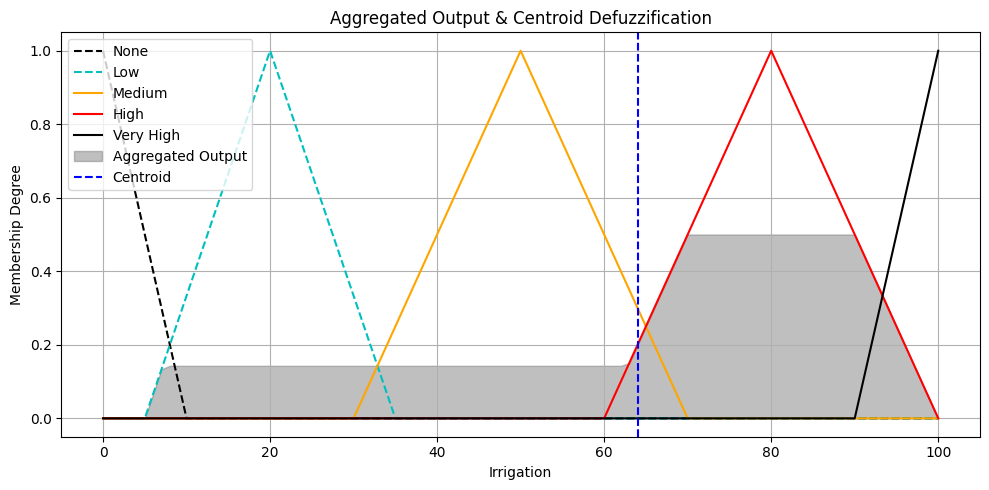

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')
plt.plot(irrigation.universe, irrigation['very_high'].mf, 'black', label='Very High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output, color='blue', linestyle='--', label='Centroid')

plt.title('Aggregated Output & Centroid Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### **First Maximum**

In [31]:
crisp_output = fuzz.defuzz(irrigation.universe, aggregated_output, 'som')
print(f"\nFinal Irrigation Output (First of Maximum): {crisp_output:.2f}")


Final Irrigation Output (First of Maximum): 70.00


###### **Visualization**

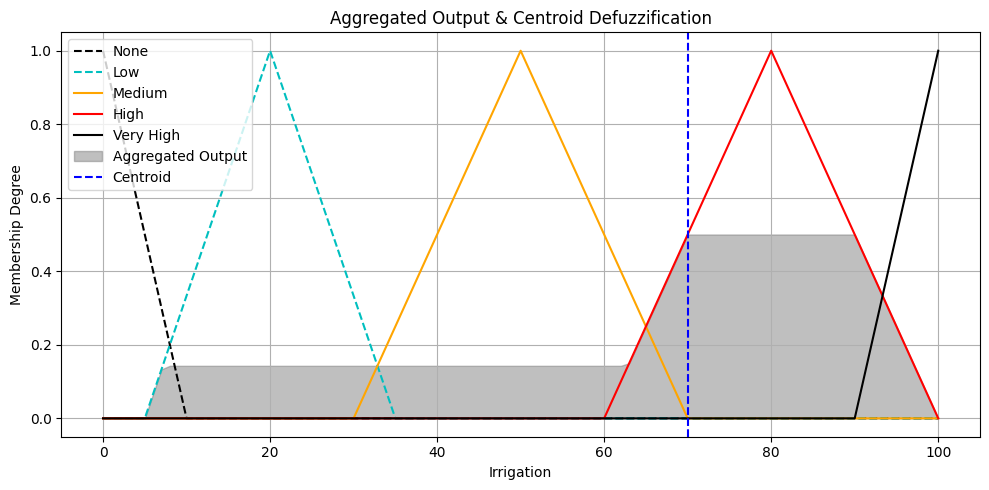

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')
plt.plot(irrigation.universe, irrigation['very_high'].mf, 'black', label='Very High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output, color='blue', linestyle='--', label='Centroid')

plt.title('Aggregated Output & Centroid Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### **Middle Maximum**

In [33]:
crisp_output = fuzz.defuzz(irrigation.universe, aggregated_output, 'mom')
print(f"\nFinal Irrigation Output (Mean of Maximum): {crisp_output:.2f}")


Final Irrigation Output (Mean of Maximum): 80.00


###### **Visualization**

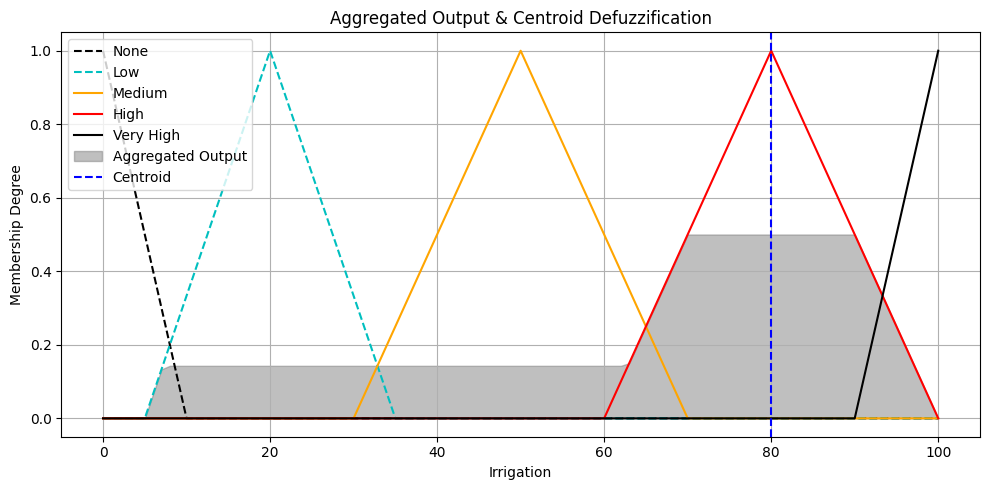

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')
plt.plot(irrigation.universe, irrigation['very_high'].mf, 'black', label='Very High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output, color='blue', linestyle='--', label='Centroid')

plt.title('Aggregated Output & Centroid Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### **Last Maximum**

In [35]:
crisp_output = fuzz.defuzz(irrigation.universe, aggregated_output, 'lom')
print(f"\nFinal Irrigation Output (Last of Maximum): {crisp_output:.2f}")


Final Irrigation Output (Last of Maximum): 90.00


###### **Visualization**

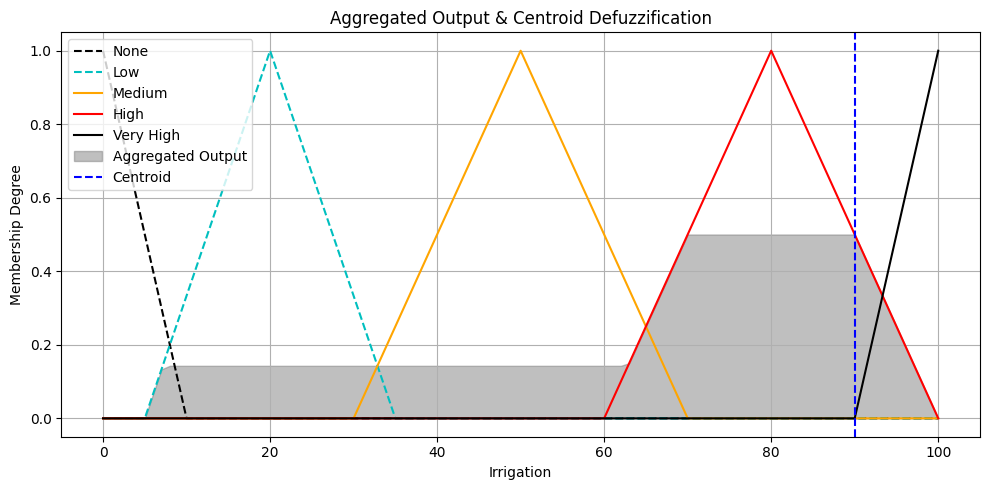

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')
plt.plot(irrigation.universe, irrigation['very_high'].mf, 'black', label='Very High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output, color='blue', linestyle='--', label='Centroid')

plt.title('Aggregated Output & Centroid Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###### **Center Of The Surface**

In [37]:
crisp_output = fuzz.defuzz(irrigation.universe, aggregated_output, 'bisector')
print(f"\nFinal Irrigation Output (bisector): {crisp_output:.2f}")


Final Irrigation Output (bisector): 72.09


###### **Visualization**

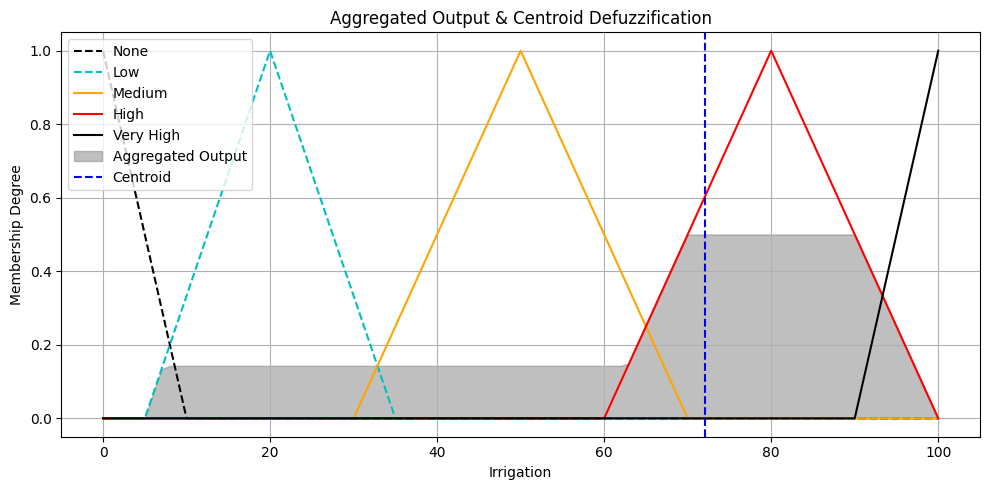

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(irrigation.universe, irrigation['none'].mf, 'k--', label='None')
plt.plot(irrigation.universe, irrigation['low'].mf, 'c--', label='Low')
plt.plot(irrigation.universe, irrigation['medium'].mf, 'orange', label='Medium')
plt.plot(irrigation.universe, irrigation['high'].mf, 'r', label='High')
plt.plot(irrigation.universe, irrigation['very_high'].mf, 'black', label='Very High')

plt.fill_between(irrigation.universe, aggregated_output, alpha=0.5, color='gray', label='Aggregated Output')
plt.axvline(crisp_output, color='blue', linestyle='--', label='Centroid')

plt.title('Aggregated Output & Centroid Defuzzification')
plt.xlabel('Irrigation')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **Simulation and Analysis**

#### **10 Day Timeframe**

Day 1: Weather=Sunny, Evap=5.98, Rain=0.00, Soil Moisture=50.00% → 66.14%, Irrigation=44.25%
Day 2: Weather=Sunny, Evap=7.33, Rain=0.00, Soil Moisture=66.14% → 75.02%, Irrigation=32.43%
Day 3: Weather=Sunny, Evap=7.86, Rain=0.00, Soil Moisture=75.02% → 76.59%, Irrigation=18.86%
Day 4: Weather=Sunny, Evap=5.13, Rain=0.00, Soil Moisture=76.59% → 80.89%, Irrigation=18.86%
Day 5: Weather=Cloudy, Evap=3.52, Rain=0.00, Soil Moisture=80.89% → 79.05%, Irrigation=3.36%
Day 6: Weather=Cloudy, Evap=2.31, Rain=0.00, Soil Moisture=79.05% → 78.41%, Irrigation=3.34%
Day 7: Weather=Cloudy, Evap=2.13, Rain=0.00, Soil Moisture=78.41% → 77.95%, Irrigation=3.35%
Day 8: Weather=Rainy, Evap=1.14, Rain=11.22, Soil Moisture=77.95% → 89.94%, Irrigation=3.79%
Day 9: Weather=Rainy, Evap=0.92, Rain=17.87, Soil Moisture=89.94% → 100.00%, Irrigation=4.23%
Day 10: Weather=Rainy, Evap=1.03, Rain=19.62, Soil Moisture=100.00% → 100.00%, Irrigation=3.79%


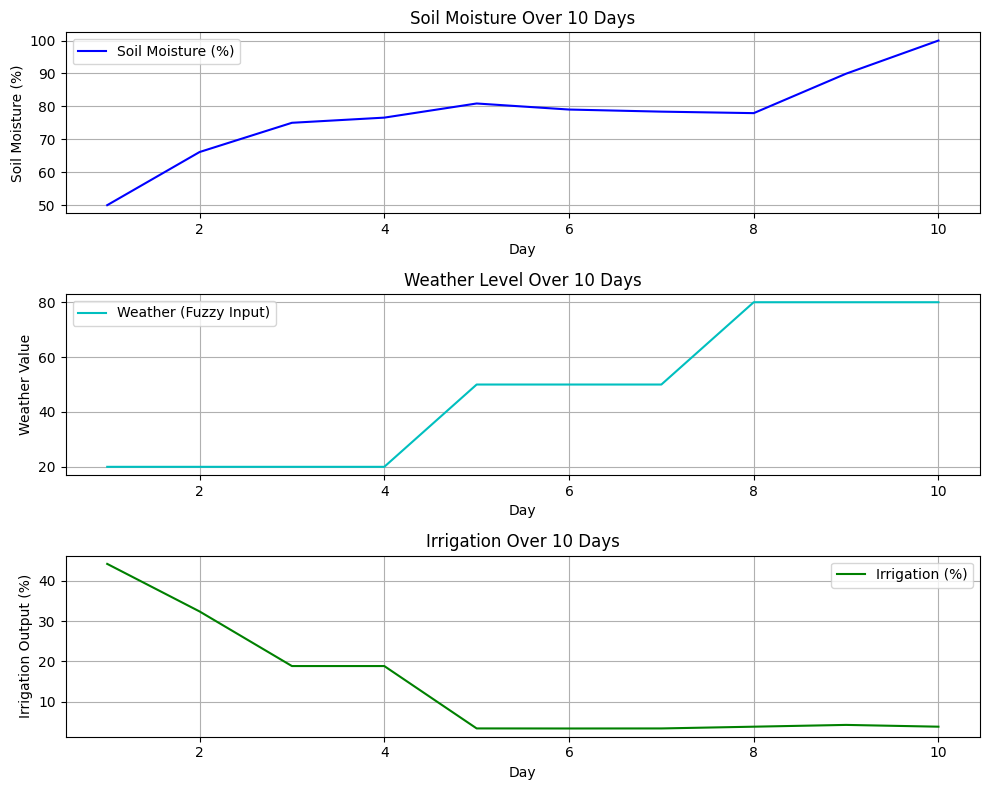

In [39]:
days = 10
soil_moisture_values = [50]  # Initial soil moisture
weather_values = []
irrigation_values = []

weather_map = {
    "Sunny": 20,
    "Cloudy": 50,
    "Rainy": 80
}

for day in range(days):
    if 0 <= day <= 3:
        weather_str = "Sunny"
        evap = np.random.uniform(5, 8)
        rain_effect = 0
    elif 4 <= day <= 6:
        weather_str = "Cloudy"
        evap = np.random.uniform(2, 4)
        rain_effect = 0
    else:
        weather_str = "Rainy"
        evap = np.random.uniform(0.5, 1.5)
        rain_effect = np.random.uniform(10, 20)  # The effect of rain on soil

    weather_values.append(weather_str)

    # Input to the fuzzy system
    soil_input = soil_moisture_values[-1]
    weather_input = weather_map[weather_str]

    irrigation_sim.input['soil'] = soil_input
    irrigation_sim.input['weather'] = weather_input
    irrigation_sim.compute()

    irrigation_amount = irrigation_sim.output['irrigation']
    irrigation_values.append(irrigation_amount)

    # Calculating new soil moisture using the modified equation
    new_moisture = soil_input - evap + (irrigation_amount * 0.5) + rain_effect
    new_moisture = np.clip(new_moisture, 0, 100)
    soil_moisture_values.append(new_moisture)

    # Print daily information
    print(f"Day {day+1}: Weather={weather_str}, Evap={evap:.2f}, Rain={rain_effect:.2f}, Soil Moisture={soil_input:.2f}% → {new_moisture:.2f}%, Irrigation={irrigation_amount:.2f}%")

# Drawing diagrams
days_axis = range(1, days + 1)
plt.figure(figsize=(10, 8))

# Soil moisture
plt.subplot(3, 1, 1)
plt.plot(days_axis, soil_moisture_values[:-1], 'b-', label='Soil Moisture (%)')
plt.title('Soil Moisture Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Soil Moisture (%)')
plt.grid(True)
plt.legend()

# Weather conditions in numbers
weather_numeric = [weather_map[w] for w in weather_values]
plt.subplot(3, 1, 2)
plt.plot(days_axis, weather_numeric, 'c-', label='Weather (Fuzzy Input)')
plt.title('Weather Level Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Weather Value')
plt.grid(True)
plt.legend()

# Irrigation
plt.subplot(3, 1, 3)
plt.plot(days_axis, irrigation_values, 'g-', label='Irrigation (%)')
plt.title('Irrigation Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Irrigation Output (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


#### **Analysis and Review**

In [40]:
# Define optimal, under, and over moisture zones
optimal_min = 40
optimal_max = 80

in_range_days = 0
under_moisture_days = 0
over_moisture_days = 0

# Categorize each day's moisture level
for moisture in soil_moisture_values[:-1]:  # Last value is t+1 and unused
    if optimal_min <= moisture <= optimal_max:
        in_range_days += 1
    elif moisture < optimal_min:
        under_moisture_days += 1
    elif moisture > optimal_max:
        over_moisture_days += 1

# Calculate percentages
success_rate = (in_range_days / days) * 100
under_rate = (under_moisture_days / days) * 100
over_rate = (over_moisture_days / days) * 100

# Display full performance analysis
print("\n📊 Detailed Performance Analysis:")
print(f"Optimal Moisture Range: {optimal_min}% to {optimal_max}%")
print(f"Days in Optimal Range: {in_range_days} ({success_rate:.2f}%)")
print(f"Days Under Optimal Range: {under_moisture_days} ({under_rate:.2f}%)")
print(f"Days Over Optimal Range: {over_moisture_days} ({over_rate:.2f}%)")

if over_rate > 40:
    print("This type of irrigation is recommended for greenhouses with high humidity.")
elif under_rate > 20:
    print("This type of irrigation is recommended for greenhouses with low humidity.")
else:
    print("The fuzzy controller maintains soil moisture efficiently within the desired range.")


📊 Detailed Performance Analysis:
Optimal Moisture Range: 40% to 80%
Days in Optimal Range: 7 (70.00%)
Days Under Optimal Range: 0 (0.00%)
Days Over Optimal Range: 3 (30.00%)
The fuzzy controller maintains soil moisture efficiently within the desired range.


## **THE END**

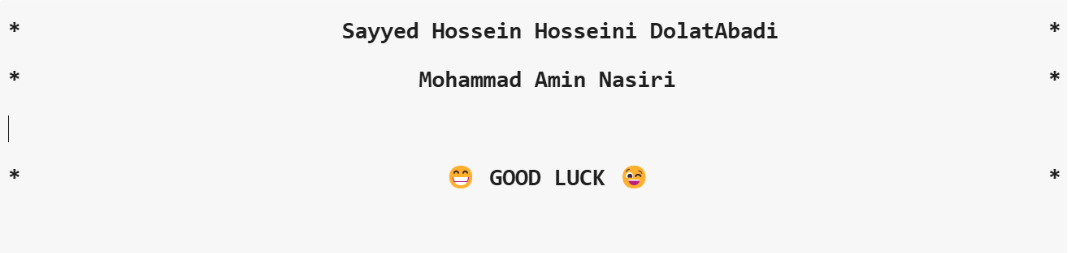